# COCS2673 Assignment 2 P1A - Is or is not cancer prediction

In [1]:
#!pip install tensorflow

In [2]:
#import zipfile
#with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
#   zip_ref.extractall('./')

In [3]:
#!pwd

In [4]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

import IPython.display as display
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

tf.__version__


'2.5.0'

# Read Data
Split data into train, validation, and test
Note that images for the same patient may contain a mix of cancerous and non-cancerous data.
Q - Sould we split on patient or just randomly



In [5]:
mainData = pd.read_csv('./data_labels_mainData.csv')
extraData = pd.read_csv('./data_labels_extraData.csv')

In [6]:
mainData.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [7]:
extraData.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


# Exploratary Data Analysis (EDA)

In [8]:
print(mainData.dtypes)
print(mainData.shape)
#print(mainData.info())
#print(mainData.describe())


InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
dtype: object
(9896, 6)


In [9]:
print(extraData.dtypes)
print(extraData.shape)
#print(extraData.info())
#print(extraData.describe())

InstanceID      int64
patientID       int64
ImageName      object
isCancerous     int64
dtype: object
(10384, 4)


There are 2 data files mainData with 6 properties and 9896 rows, and extraData with 4 properties and 10384 rows.

For part1, the aim is to predict if a slide is cancerous or not from the image data.
Lets append data and confirm the number of images matches the input data rows.

In [10]:
#mainData = mainData.sample(2000)   # Sampling used for inital model development
mainData = mainData.append(extraData, ignore_index=True)

In [11]:
mainData.shape[0]

20280

In [12]:
import glob

image_list = set()
for filepath in glob.glob('./patch_images/*', recursive=True): #assuming gif
    filename = filepath.split("\\")[-1]
    image_list.add(filename)
    
print(len(image_list))

20280


The number of images matches the records.

Update Categorical Data types

In [13]:
mainData['cellType'] = mainData['cellType'].astype('category')
mainData['cellTypeName'] = mainData['cellTypeName'].astype('category')


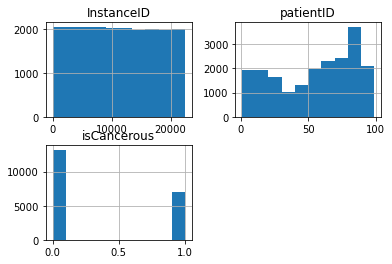

In [14]:
mainData.hist()
plt.show()

In [15]:
mainData.drop(['InstanceID'], axis=1,inplace=True)
mainData.drop(['cellType'], axis=1,inplace=True)
mainData.drop(['cellTypeName'], axis=1,inplace=True)


In [16]:
mainData['isCancerous'] = mainData['isCancerous'].astype('category')


In [17]:
mainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20280 entries, 0 to 20279
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   patientID    20280 non-null  int64   
 1   ImageName    20280 non-null  object  
 2   isCancerous  20280 non-null  category
dtypes: category(1), int64(1), object(1)
memory usage: 336.9+ KB


In [18]:
mainData.isnull().sum()

patientID      0
ImageName      0
isCancerous    0
dtype: int64

**There are no missing values in the datasets.**

In [19]:
def BinBreakdown(desc, data):
    neg, pos = np.bincount(data)
    total = neg + pos
    print('{} Class Data:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(desc, total, pos, 100 * pos / total))

In [20]:
BinBreakdown('Input Data', mainData.isCancerous)

Input Data Class Data:
    Total: 20280
    Positive: 7069 (34.86% of total)



#### Key observations:
* Data has 20280  observations and 6 columns.
* InstanceID - is Id field, need to remove as not valueable classification attribute
* cellTypeName, cellType - indicator of actual cell type and not used in this case for cancer diagnosis
* isCancerous - indicator of the actual diagnosis (1 = cancerous, 0 = benign)
* image count matches data rows 

Split of benign to cancerous is a 35% cancerous, 65% benign

* The class value is boolean so doesn't have outliers etc to consider

# Train/Validation/Test Split on Patients

### Add classification class

In [21]:
mainData['isCancerous'] = mainData['isCancerous'].astype('str')

### Split Data into Train/Validate/Test
For test and training data split via person.
This assumes that if a person has cancer or not, then would the images for that person have cancer.
Also different cell types per person would be used for validation/testing.

In [22]:
# Get list of patients and observation counts
# Allocate approc 25% of data for Validation and Testing - of that 60%/40% for validation/test split.
TEST_RATIO = 0.10
VAL_RATIO = 0.15


In [23]:
# Split train tests by ratios
# Select random patients until the number of images for 
# each patient sums to the number of records require

np.random.seed(43) # Consistent random list

recCount = mainData.shape[0]
custRec = mainData.patientID.value_counts().to_dict()
    
patientIds = list(custRec.keys())

# Loop through selecting a patient at random summing the number of images they have
# until the count of images crosses is more than required number

testCust = []
testRecs = 0
while (testRecs < (recCount * TEST_RATIO)):
    pId = np.random.choice(patientIds)
    ic = custRec.get(pId)
    patientIds.remove(pId)
    testCust.append(pId)
    testRecs += ic
    
#print(testCust, testRecs)

valCust = []
valRecs = 0
while (valRecs < (recCount * VAL_RATIO)):
    pId = np.random.choice(patientIds)
    ic = custRec.get(pId)
    patientIds.remove(pId)
    valCust.append(pId)
    valRecs += ic

#print(valCust, valRecs)

In [24]:
testData = mainData[mainData.patientID.isin(testCust)]
valData = mainData[mainData.patientID.isin(valCust)]
trainData = mainData[~(mainData.patientID.isin(valCust + testCust))]

In [25]:
totalRecs = mainData.shape[0]
#print(trainData.shape[0] + valData.shape[0] + testData.shape[0])

print("Train data : {}, Val Data: {}, Test Data: {}".format(trainData.shape[0], valData.shape[0], testData.shape[0]))
print("Train data : {:.2f}%, Val Data: {:.2f}%, Test Data: {:.2f}%".format(
    100 * trainData.shape[0] / totalRecs, 100 * valData.shape[0]/totalRecs, 100 * testData.shape[0]/totalRecs))

Train data : 15054, Val Data: 3055, Test Data: 2171
Train data : 74.23%, Val Data: 15.06%, Test Data: 10.71%


In [26]:
trainData.head()

,patientID,ImageName,isCancerous
19,2,19035.png,0
20,2,19036.png,0
21,2,19037.png,0
22,2,19038.png,0
23,2,19039.png,0


In [27]:
BinBreakdown('Train', trainData.isCancerous)
BinBreakdown('Validation', valData.isCancerous)
BinBreakdown('Test', testData.isCancerous)

Train Class Data:
    Total: 15054
    Positive: 5055 (33.58% of total)

Validation Class Data:
    Total: 3055
    Positive: 1252 (40.98% of total)

Test Class Data:
    Total: 2171
    Positive: 762 (35.10% of total)



([0, 1], [Text(0, 0, ''), Text(0, 0, '')])

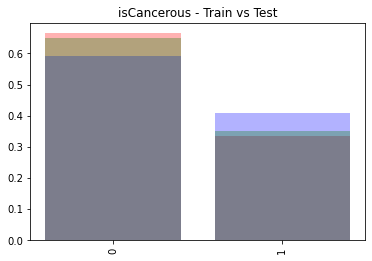

In [28]:
plt.bar(
    trainData.isCancerous.value_counts().index.astype(str), 
    trainData.isCancerous.value_counts().values/np.sum(trainData.isCancerous.value_counts().values), 
    alpha=0.3, 
    color='r')

plt.bar(
    valData.isCancerous.value_counts().index.astype(str), 
    valData.isCancerous.value_counts().values/np.sum(valData.isCancerous.value_counts().values), 
    alpha=0.3, 
    color='b')

plt.bar(
    testData.isCancerous.value_counts().index.astype(str), 
    testData.isCancerous.value_counts().values/np.sum(testData.isCancerous.value_counts().values), 
    alpha=0.3, 
    color='g')

plt.title('isCancerous - Train vs Test')
plt.xticks(rotation='vertical')

**Observations:**
1. Train/Validation/Test data distributions sets have similar distributions

# Images
27x27 RGB 

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=valData,
        directory='patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = val_datagen.flow_from_dataframe(
        dataframe=testData,
        directory='patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 15054 validated image filenames belonging to 2 classes.
Found 3055 validated image filenames belonging to 2 classes.
Found 2171 validated image filenames belonging to 2 classes.


### Utility Functions

In [30]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [31]:
def PlotModelFitHistory(mh):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(mh.history['loss'], 'r--')
    plt.plot(mh.history['val_loss'], 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(mh.history['categorical_accuracy'], 'r--')
    plt.plot(mh.history['val_categorical_accuracy'], 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()


In [32]:
def PlotConfusionMatrix(test, pred):
    cm = confusion_matrix(test, pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# Model Development

### Measure 
As this is a screening/detection task, the impact of a false negative is high (ie someone who has cancer is missed)
In this case use Recall for measure.
We can also use F1 to get a more balanced measure of Precision and Recall

In [33]:
def CompileModel(model):
    opt = tf.keras.optimizers.Adagrad()
    model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])    

In [34]:
# using patience here - could use other limits
early_stopping_monitor = EarlyStopping(patience=30, monitor='val_categorical_accuracy')

def FitModel(model):

    print('start ', datetime.datetime.now().strftime("%H:%M:%S"))
    now = datetime.datetime.now()

    fit_history = model.fit(train_generator, validation_data = validation_generator, 
                            callbacks=[early_stopping_monitor], epochs=10000, verbose=1)

    print('stop ', datetime.datetime.now().strftime("%H:%M:%S"))
    print("Took = ", datetime.datetime.now() - now)
    
    return fit_history

In [35]:
def PredictModel(model):
    batch_size_ = 1
    y_pred = list()
    y_test = list()
    filenames = test_generator.filenames
    N_images = len(filenames)
    batches = 0

    # iterate through the data generator and predict for each batch
    # hold the predictions and labels
    for x,y in test_generator:
            yp = model.predict(x, verbose=0)
            yp = np.argmax(yp, axis = 1)
            yt = np.argmax(y, axis = 1)
            y_pred = y_pred + yp.tolist()
            y_test = y_test + yt.tolist()

            batches += 1
            if batches >= N_images / batch_size_:
                break
                
    return (y_test, y_pred)

In [36]:
def ShowStats(y_test, y_pred):
    print("Accuracy score: ", accuracy_score(test_y, pred_y))
    print("F1 score: ", f1_score(test_y, pred_y, average='macro'))

    print(classification_report(test_y, pred_y, zero_division=0))

### Model Inputs

In [37]:
INPUT_DIM = (27,27,3)
OUTPUT_CLASSES = 2       # TensorFlow automatically does one hot encoding to our target label

## 1. Baseline an simple MLP Model
Observations
* Use a initial NN to get a baseline
* Binary classification problem
* Input has 2187 dims (this is small for image recognition)
* 1 hidden layer with 256 internal nodes
* 1 output binary
* Loss - Binary Cross Entropy
* Metric - binary_accuracy 
* use sigmoid activation as this is a logistics issue



In [38]:
model_base = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid')
])

In [39]:
model_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               560128    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


In [40]:
CompileModel(model_base)

In [41]:
history_base = FitModel(model_base)

start  19:56:48
Epoch 1/10000
471/471 [==============================] - 7s 15ms/step - loss: 0.5069 - categorical_accuracy: 0.7483 - val_loss: 0.4985 - val_categorical_accuracy: 0.7218
Epoch 2/10000
471/471 [==============================] - 7s 15ms/step - loss: 0.4110 - categorical_accuracy: 0.8212 - val_loss: 0.3840 - val_categorical_accuracy: 0.8488
Epoch 3/10000
471/471 [==============================] - 8s 18ms/step - loss: 0.3835 - categorical_accuracy: 0.8345 - val_loss: 0.3970 - val_categorical_accuracy: 0.8232
Epoch 4/10000
471/471 [==============================] - 8s 17ms/step - loss: 0.3726 - categorical_accuracy: 0.8396 - val_loss: 0.3719 - val_categorical_accuracy: 0.8376
Epoch 5/10000
471/471 [==============================] - 8s 16ms/step - loss: 0.3657 - categorical_accuracy: 0.8398 - val_loss: 0.3584 - val_categorical_accuracy: 0.8547
Epoch 6/10000
471/471 [==============================] - 8s 16ms/step - loss: 0.3615 - categorical_accuracy: 0.8440 - val_loss: 0.3628

471/471 [==============================] - 8s 17ms/step - loss: 0.3361 - categorical_accuracy: 0.8544 - val_loss: 0.3501 - val_categorical_accuracy: 0.8498
Epoch 46/10000
471/471 [==============================] - 8s 16ms/step - loss: 0.3358 - categorical_accuracy: 0.8543 - val_loss: 0.3612 - val_categorical_accuracy: 0.8426
Epoch 47/10000
471/471 [==============================] - 8s 17ms/step - loss: 0.3360 - categorical_accuracy: 0.8543 - val_loss: 0.3515 - val_categorical_accuracy: 0.8488 categorical_accu - ETA: 0s - loss: 0.3357 - categorical_accuracy:  - ETA: 0s - loss: 0.3350 - categorical_accu
Epoch 48/10000
471/471 [==============================] - 8s 17ms/step - loss: 0.3348 - categorical_accuracy: 0.8565 - val_loss: 0.3423 - val_categorical_accuracy: 0.8579
Epoch 49/10000
471/471 [==============================] - 8s 17ms/step - loss: 0.3354 - categorical_accuracy: 0.8562 - val_loss: 0.3397 - val_categorical_accuracy: 0.8592
Epoch 50/10000
471/471 [=========================

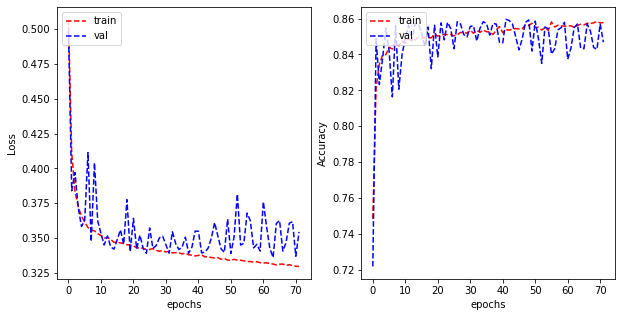

In [42]:
PlotModelFitHistory(history_base)

In [43]:
(test_y, pred_y) = PredictModel(model_base)

In [44]:
ShowStats(test_y, pred_y)

Accuracy score:  0.8553168775336497
F1 score:  0.8286254355163871
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     44986
           1       0.91      0.66      0.76     24331

    accuracy                           0.86     69317
   macro avg       0.87      0.81      0.83     69317
weighted avg       0.86      0.86      0.85     69317



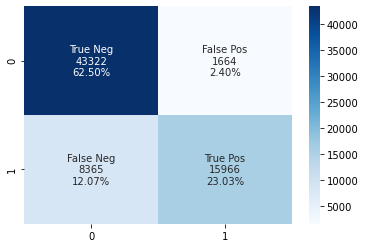

In [45]:
PlotConfusionMatrix(test_y, pred_y)

### Observation
* Train vs Validation approaches at 150 epocs
* There is significant overfitting of model after a short number of epochs
* Results show no detection of cancorous images - not usable
* Instability in accuracy could indicate too high learning rate


## 2. Base Model with regularisation
To reduce overfitting try regularisation

In [46]:
# Use default lambda - note for assignment only. In real this might be in loop to determine best value.
reg_lambda = 0.01

model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(256, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [47]:
model_reg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               560128    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


In [48]:
CompileModel(model_reg)

In [49]:
history_reg = FitModel(model_reg)

start  20:07:49
Epoch 1/10000
471/471 [==============================] - 10s 19ms/step - loss: 5.1019 - categorical_accuracy: 0.6644 - val_loss: 4.9991 - val_categorical_accuracy: 0.5902
Epoch 2/10000
471/471 [==============================] - 9s 19ms/step - loss: 4.7992 - categorical_accuracy: 0.6796 - val_loss: 4.6870 - val_categorical_accuracy: 0.6334A: 5s - loss: 4.9073 - categorical_accuracy: 0. - ETA: 5s - ETA: 3s - loss: 4.8713 - categorical_ - ETA: 3s - loss: 4.8630 - categorical_accuracy:  - ETA: 3s - loss: 4.8586 - categorical_accuracy:  - ETA
Epoch 3/10000
471/471 [==============================] - 9s 19ms/step - loss: 4.5269 - categorical_accuracy: 0.7218 - val_loss: 4.4222 - val_categorical_accuracy: 0.7021A: 4s - loss: 4.6104 - categorical_accura - ETA: 4s - l - ETA: 1s - loss: 4.5530 - categorical_accura - ETA: 1s - loss: 4.5479 -  - ETA: 0s - loss: 4.5341 - categorical_
Epoch 4/10000
471/471 [==============================] - 9s 20ms/step - loss: 4.2794 - categorical_ac

471/471 [==============================] - 9s 19ms/step - loss: 1.2743 - categorical_accuracy: 0.8434 - val_loss: 1.2552 - val_categorical_accuracy: 0.8455ategorical_ac - ETA: 4s - loss: 1.2850 - categorical_accu - ETA: 2s - loss: 1.2796 - categorical_accuracy: 0. - ETA: 2s - loss: 1.2800 - categorical_ac - ETA: 1s - loss: 1.2780 - categorical_accu - ETA: 1s - loss: 1.2769 - categorical_accuracy: 0. - ETA: 1s - loss: 1.2780 - categorical_accuracy: 0.84 - ETA: 1s - loss: 1.2780 - categori - ETA: 0s - loss: 1.2756 - categorical_accuracy - ETA: 0s - loss: 1.2753 - categorical_ac
Epoch 33/10000
471/471 [==============================] - 9s 18ms/step - loss: 1.2337 - categorical_accuracy: 0.8434 - val_loss: 1.2264 - val_categorical_accuracy: 0.8278 categorical_accuracy - ETA: 5s - loss: 1.2 - ETA: 3s - loss: 1.2446 - ca - ETA: 2s - loss: 1.239 - ETA
Epoch 34/10000
471/471 [==============================] - 9s 19ms/step - loss: 1.1954 - categorical_accuracy: 0.8434 - val_loss: 1.1804 - val_c

471/471 [==============================] - 9s 19ms/step - loss: 0.6983 - categorical_accuracy: 0.8442 - val_loss: 0.6974 - val_categorical_accuracy: 0.8435 2s - loss: 0.7009 - categorical_accuracy - ETA: 2s - loss: 0.7014  - ETA: 1s - loss: 0.7002 - categorical_accuracy:  - ETA: 1s - loss: 0.6998 - categorical_accu - ETA: 0s - loss: 0.6997 - cate
Epoch 58/10000
471/471 [==============================] - 9s 19ms/step - loss: 0.6881 - categorical_accuracy: 0.8462 - val_loss: 0.6872 - val_categorical_accuracy: 0.8445
Epoch 59/10000
471/471 [==============================] - 9s 18ms/step - loss: 0.6774 - categorical_accuracy: 0.8459 - val_loss: 0.6734 - val_categorical_accuracy: 0.8445egorical_accuracy: 0. - ETA: 4s - loss: 0.6837 - categorical_accuracy - ETA: 4s - loss: 0.681 - ETA: 1s - loss: 0.6767 - categorical_accura - ETA: 1s - loss: 0.6771 - ca - ETA: 0s - loss: 0.6772 - catego
Epoch 60/10000
471/471 [==============================] - 8s 18ms/step - loss: 0.6674 - categorical_accura

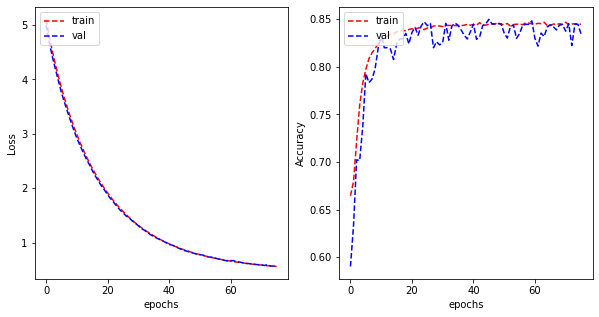

In [50]:
PlotModelFitHistory(history_reg)

In [51]:
(test_y, pred_y) = PredictModel(model_reg)

In [52]:
ShowStats(test_y, pred_y)

Accuracy score:  0.8429709141274239
F1 score:  0.8125716919200051
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     44989
           1       0.89      0.63      0.74     24323

    accuracy                           0.84     69312
   macro avg       0.86      0.79      0.81     69312
weighted avg       0.85      0.84      0.84     69312



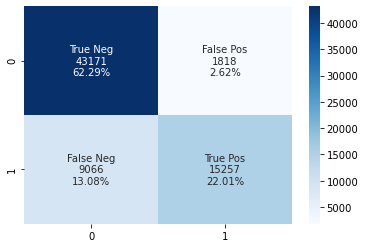

In [53]:
PlotConfusionMatrix(test_y, pred_y)

### Observation
* Loss vs Epochs plot shows significantly improved fitting
* Accuracy stablises at ~ 80% after 20 epochs
* Learning rate maybe still high but results good
* Model doesn't detect positive cases

## 3. Base Model with dropout
To reduce overfitting and improve speed see if minor drop out improves the model.

In [54]:
model_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid')
])

In [55]:
model_drop.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               560128    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


In [56]:
CompileModel(model_drop)

In [57]:
history_drop = FitModel(model_drop)

start  20:20:29
Epoch 1/10000
471/471 [==============================] - 8s 17ms/step - loss: 0.5295 - categorical_accuracy: 0.7325 - val_loss: 0.4676 - val_categorical_accuracy: 0.77745324 - categorical_accura
Epoch 2/10000
471/471 [==============================] - 8s 16ms/step - loss: 0.4302 - categorical_accuracy: 0.8075 - val_loss: 0.4747 - val_categorical_accuracy: 0.7561
Epoch 3/10000
471/471 [==============================] - 8s 16ms/step - loss: 0.4015 - categorical_accuracy: 0.8244 - val_loss: 0.4244 - val_categorical_accuracy: 0.8033s - loss: 0.406 - ETA: 0s - loss: 0.4041 - 
Epoch 4/10000
471/471 [==============================] - 8s 17ms/step - loss: 0.3862 - categorical_accuracy: 0.8324 - val_loss: 0.3695 - val_categorical_accuracy: 0.84650.3866 - categorical_accuracy: 0.
Epoch 5/10000
471/471 [==============================] - 8s 16ms/step - loss: 0.3787 - categorical_accuracy: 0.8353 - val_loss: 0.3636 - val_categorical_accuracy: 0.8471
Epoch 6/10000
471/471 [==========

471/471 [==============================] - 8s 17ms/step - loss: 0.3386 - categorical_accuracy: 0.8520 - val_loss: 0.3405 - val_categorical_accuracy: 0.8589
Epoch 46/10000
471/471 [==============================] - 8s 17ms/step - loss: 0.3378 - categorical_accuracy: 0.8521 - val_loss: 0.3511 - val_categorical_accuracy: 0.8517orical_accuracy: 
Epoch 47/10000
471/471 [==============================] - 8s 17ms/step - loss: 0.3375 - categorical_accuracy: 0.8526 - val_loss: 0.3404 - val_categorical_accuracy: 0.8579
Epoch 48/10000
471/471 [==============================] - 8s 17ms/step - loss: 0.3381 - categorical_accuracy: 0.8513 - val_loss: 0.3511 - val_categorical_accuracy: 0.8498
Epoch 49/10000
471/471 [==============================] - 8s 17ms/step - loss: 0.3376 - categorical_accuracy: 0.8541 - val_loss: 0.3416 - val_categorical_accuracy: 0.8563
Epoch 50/10000
471/471 [==============================] - 8s 17ms/step - loss: 0.3361 - categorical_accuracy: 0.8522 - val_loss: 0.3398 - val_c

Epoch 92/10000
471/471 [==============================] - 8s 16ms/step - loss: 0.3252 - categorical_accuracy: 0.8586 - val_loss: 0.3448 - val_categorical_accuracy: 0.8540s - loss: 0.3265 - categorica
Epoch 93/10000
471/471 [==============================] - 8s 16ms/step - loss: 0.3246 - categorical_accuracy: 0.8600 - val_loss: 0.3379 - val_categorical_accuracy: 0.8576
Epoch 94/10000
471/471 [==============================] - 8s 16ms/step - loss: 0.3250 - categorical_accuracy: 0.8598 - val_loss: 0.3446 - val_categorical_accuracy: 0.8534s - loss: 0.3498 - cate - ETA: 3s - loss: 0 - ETA: 2s - loss: 0.329
Epoch 95/10000
471/471 [==============================] - 8s 16ms/step - loss: 0.3233 - categorical_accuracy: 0.8596 - val_loss: 0.3323 - val_categorical_accuracy: 0.8606
Epoch 96/10000
471/471 [==============================] - 8s 16ms/step - loss: 0.3233 - categorical_accuracy: 0.8618 - val_loss: 0.3388 - val_categorical_accuracy: 0.8583: 0.3246 
Epoch 97/10000
471/471 [================

471/471 [==============================] - 9s 18ms/step - loss: 0.3167 - categorical_accuracy: 0.8636 - val_loss: 0.3431 - val_categorical_accuracy: 0.8524- ETA: 0s - loss: 0.3174 - cate
Epoch 134/10000
471/471 [==============================] - 8s 17ms/step - loss: 0.3157 - categorical_accuracy: 0.8653 - val_loss: 0.3399 - val_categorical_accuracy: 0.8566
Epoch 135/10000
471/471 [==============================] - 8s 16ms/step - loss: 0.3161 - categorical_accuracy: 0.8634 - val_loss: 0.3391 - val_categorical_accuracy: 0.8556 - categorical_ - ETA: 0s - loss: 0.3157 - categori
Epoch 136/10000
471/471 [==============================] - 8s 17ms/step - loss: 0.3151 - categorical_accuracy: 0.8652 - val_loss: 0.3354 - val_categorical_accuracy: 0.8606
Epoch 137/10000
471/471 [==============================] - 8s 16ms/step - loss: 0.3159 - categorical_accuracy: 0.8650 - val_loss: 0.3494 - val_categorical_accuracy: 0.84983165 - categorica
Epoch 138/10000
471/471 [==============================] 

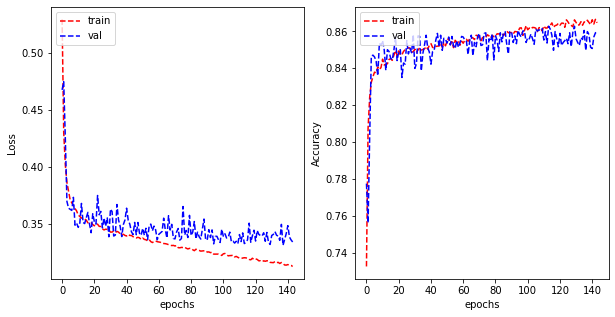

In [58]:
PlotModelFitHistory(history_drop)

In [59]:
(test_y, pred_y) = PredictModel(model_drop)

In [60]:
ShowStats(test_y, pred_y)

Accuracy score:  0.8750577100646353
F1 score:  0.8552891690167195
              precision    recall  f1-score   support

           0       0.86      0.96      0.91     44993
           1       0.90      0.72      0.80     24319

    accuracy                           0.88     69312
   macro avg       0.88      0.84      0.86     69312
weighted avg       0.88      0.88      0.87     69312



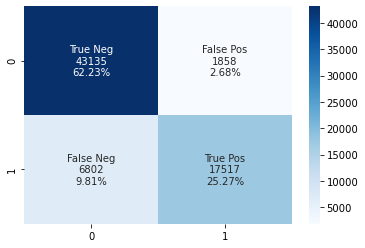

In [61]:
PlotConfusionMatrix(test_y, pred_y)

## Observation
* Dropout also improves but test data looks to be better than training
* This may be result of the data but there also looks to be some overfitting
* This doesn't appear to improve on model 2

## 4. Baseline Plus VGG
Using an initial set of convolution layers may improve input to the MLP layers
Use standard VGG architecture to check if this provides better results

In [62]:
model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid' )
])

In [63]:
CompileModel(model_VGG_1)

In [64]:
history_VGG_1 = FitModel(model_VGG_1)

start  20:41:01
Epoch 1/10000
471/471 [==============================] - 35s 73ms/step - loss: 0.6297 - categorical_accuracy: 0.6642 - val_loss: 0.6685 - val_categorical_accuracy: 0.5902
Epoch 2/10000
471/471 [==============================] - 34s 72ms/step - loss: 0.6144 - categorical_accuracy: 0.6642 - val_loss: 0.6462 - val_categorical_accuracy: 0.5902
Epoch 3/10000
471/471 [==============================] - 33s 71ms/step - loss: 0.5769 - categorical_accuracy: 0.6686 - val_loss: 0.5643 - val_categorical_accuracy: 0.6255
Epoch 4/10000
471/471 [==============================] - 33s 71ms/step - loss: 0.4867 - categorical_accuracy: 0.7675 - val_loss: 0.4421 - val_categorical_accuracy: 0.7797
Epoch 5/10000
471/471 [==============================] - 34s 71ms/step - loss: 0.4362 - categorical_accuracy: 0.7951 - val_loss: 0.3872 - val_categorical_accuracy: 0.8196
Epoch 6/10000
471/471 [==============================] - 33s 71ms/step - loss: 0.4096 - categorical_accuracy: 0.8100 - val_loss: 

471/471 [==============================] - 33s 69ms/step - loss: 0.2937 - categorical_accuracy: 0.8752 - val_loss: 0.3175 - val_categorical_accuracy: 0.8714
Epoch 49/10000
471/471 [==============================] - 33s 70ms/step - loss: 0.2922 - categorical_accuracy: 0.8778 - val_loss: 0.3146 - val_categorical_accuracy: 0.8723
Epoch 50/10000
471/471 [==============================] - 33s 70ms/step - loss: 0.2927 - categorical_accuracy: 0.8762 - val_loss: 0.3130 - val_categorical_accuracy: 0.8723
Epoch 51/10000
471/471 [==============================] - 33s 70ms/step - loss: 0.2911 - categorical_accuracy: 0.8755 - val_loss: 0.3211 - val_categorical_accuracy: 0.8678
Epoch 52/10000
471/471 [==============================] - 33s 69ms/step - loss: 0.2909 - categorical_accuracy: 0.8764 - val_loss: 0.3130 - val_categorical_accuracy: 0.8710
Epoch 53/10000
471/471 [==============================] - 33s 70ms/step - loss: 0.2901 - categorical_accuracy: 0.8788 - val_loss: 0.3151 - val_categorical_

Epoch 96/10000
471/471 [==============================] - 34s 72ms/step - loss: 0.2634 - categorical_accuracy: 0.8899 - val_loss: 0.3087 - val_categorical_accuracy: 0.8766
Epoch 97/10000
471/471 [==============================] - 34s 72ms/step - loss: 0.2629 - categorical_accuracy: 0.8914 - val_loss: 0.3039 - val_categorical_accuracy: 0.8769
Epoch 98/10000
471/471 [==============================] - 34s 72ms/step - loss: 0.2607 - categorical_accuracy: 0.8916 - val_loss: 0.3062 - val_categorical_accuracy: 0.8756
Epoch 99/10000
471/471 [==============================] - 34s 71ms/step - loss: 0.2621 - categorical_accuracy: 0.8909 - val_loss: 0.3039 - val_categorical_accuracy: 0.8805
Epoch 100/10000
471/471 [==============================] - 34s 72ms/step - loss: 0.2605 - categorical_accuracy: 0.8918 - val_loss: 0.3053 - val_categorical_accuracy: 0.8792
Epoch 101/10000
471/471 [==============================] - 34s 73ms/step - loss: 0.2591 - categorical_accuracy: 0.8916 - val_loss: 0.3076 -

471/471 [==============================] - 34s 71ms/step - loss: 0.2436 - categorical_accuracy: 0.8984 - val_loss: 0.3029 - val_categorical_accuracy: 0.8799
Epoch 144/10000
471/471 [==============================] - 34s 73ms/step - loss: 0.2432 - categorical_accuracy: 0.8996 - val_loss: 0.3011 - val_categorical_accuracy: 0.8795
Epoch 145/10000
471/471 [==============================] - 33s 70ms/step - loss: 0.2432 - categorical_accuracy: 0.9000 - val_loss: 0.3037 - val_categorical_accuracy: 0.8799
Epoch 146/10000
471/471 [==============================] - 33s 70ms/step - loss: 0.2422 - categorical_accuracy: 0.9006 - val_loss: 0.3125 - val_categorical_accuracy: 0.8805
Epoch 147/10000
471/471 [==============================] - 33s 70ms/step - loss: 0.2421 - categorical_accuracy: 0.9021 - val_loss: 0.3202 - val_categorical_accuracy: 0.8756
Epoch 148/10000
471/471 [==============================] - 33s 70ms/step - loss: 0.2412 - categorical_accuracy: 0.9010 - val_loss: 0.3107 - val_categor

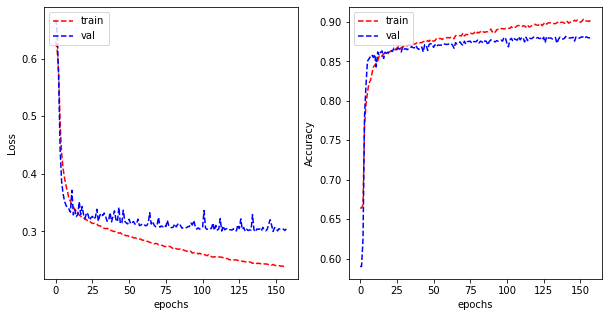

In [65]:
PlotModelFitHistory(history_VGG_1)

In [66]:
(test_y, pred_y) = PredictModel(model_VGG_1)

In [67]:
ShowStats(test_y, pred_y)

Accuracy score:  0.8940298938134811
F1 score:  0.877700271832098
              precision    recall  f1-score   support

           0       0.88      0.97      0.92     44956
           1       0.93      0.75      0.83     24356

    accuracy                           0.89     69312
   macro avg       0.91      0.86      0.88     69312
weighted avg       0.90      0.89      0.89     69312



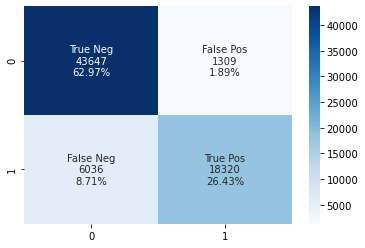

In [68]:
PlotConfusionMatrix(test_y, pred_y)

### Observation
Issue is over fitting 
* This model took much longer to train.
* Reviewing the input size that VGG was designed for the number of inputs is much reduced.
* Lets reduce the number of convolutions layers and converlutions in the layer to improve training times.

## 5. VGG 2 with simplified convolutions
* We have 20k images so that should be ok for training
* image size is small so down scaling is not too beneficial
* after 40 epics so could stop early 
* over fitting so reduce the number of convolutions
* Given number of images, data augmentation probably not required


In [69]:
model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid' )
])

In [70]:
CompileModel(model_VGG_2)

In [71]:
history_VGG_2 = FitModel(model_VGG_2)

start  22:11:51
Epoch 1/10000
471/471 [==============================] - 28s 59ms/step - loss: 0.6648 - categorical_accuracy: 0.6419 - val_loss: 0.6884 - val_categorical_accuracy: 0.5902
Epoch 2/10000
471/471 [==============================] - 28s 59ms/step - loss: 0.6585 - categorical_accuracy: 0.6452 - val_loss: 0.6844 - val_categorical_accuracy: 0.5902
Epoch 3/10000
471/471 [==============================] - 29s 61ms/step - loss: 0.6544 - categorical_accuracy: 0.6467 - val_loss: 0.6842 - val_categorical_accuracy: 0.5902
Epoch 4/10000
471/471 [==============================] - 30s 63ms/step - loss: 0.6451 - categorical_accuracy: 0.6570 - val_loss: 0.6699 - val_categorical_accuracy: 0.5902
Epoch 5/10000
471/471 [==============================] - 29s 61ms/step - loss: 0.6354 - categorical_accuracy: 0.6614 - val_loss: 0.6643 - val_categorical_accuracy: 0.5902
Epoch 6/10000
471/471 [==============================] - 28s 59ms/step - loss: 0.6196 - categorical_accuracy: 0.6674 - val_loss: 

471/471 [==============================] - 27s 58ms/step - loss: 0.3234 - categorical_accuracy: 0.8622 - val_loss: 0.3200 - val_categorical_accuracy: 0.8651
Epoch 49/10000
471/471 [==============================] - 28s 60ms/step - loss: 0.3247 - categorical_accuracy: 0.8629 - val_loss: 0.3212 - val_categorical_accuracy: 0.8612
Epoch 50/10000
471/471 [==============================] - 28s 59ms/step - loss: 0.3252 - categorical_accuracy: 0.8614 - val_loss: 0.3295 - val_categorical_accuracy: 0.8606
Epoch 51/10000
471/471 [==============================] - 29s 62ms/step - loss: 0.3225 - categorical_accuracy: 0.8608 - val_loss: 0.3247 - val_categorical_accuracy: 0.8602
Epoch 52/10000
471/471 [==============================] - 27s 58ms/step - loss: 0.3214 - categorical_accuracy: 0.8644 - val_loss: 0.3322 - val_categorical_accuracy: 0.8583
Epoch 53/10000
471/471 [==============================] - 28s 59ms/step - loss: 0.3206 - categorical_accuracy: 0.8636 - val_loss: 0.3214 - val_categorical_

Epoch 96/10000
471/471 [==============================] - 28s 59ms/step - loss: 0.3066 - categorical_accuracy: 0.8706 - val_loss: 0.3134 - val_categorical_accuracy: 0.8674
Epoch 97/10000
471/471 [==============================] - 27s 58ms/step - loss: 0.3038 - categorical_accuracy: 0.8719 - val_loss: 0.3132 - val_categorical_accuracy: 0.8668
Epoch 98/10000
471/471 [==============================] - 27s 58ms/step - loss: 0.3047 - categorical_accuracy: 0.8711 - val_loss: 0.3210 - val_categorical_accuracy: 0.8674
Epoch 99/10000
471/471 [==============================] - 27s 57ms/step - loss: 0.3039 - categorical_accuracy: 0.8699 - val_loss: 0.3124 - val_categorical_accuracy: 0.8681
Epoch 100/10000
471/471 [==============================] - 27s 57ms/step - loss: 0.3030 - categorical_accuracy: 0.8728 - val_loss: 0.3120 - val_categorical_accuracy: 0.8668
Epoch 101/10000
471/471 [==============================] - 27s 57ms/step - loss: 0.3044 - categorical_accuracy: 0.8724 - val_loss: 0.3142 -

471/471 [==============================] - 27s 56ms/step - loss: 0.2938 - categorical_accuracy: 0.8764 - val_loss: 0.3127 - val_categorical_accuracy: 0.8700
Epoch 144/10000
471/471 [==============================] - 27s 57ms/step - loss: 0.2946 - categorical_accuracy: 0.8760 - val_loss: 0.3152 - val_categorical_accuracy: 0.8694
Epoch 145/10000
471/471 [==============================] - 27s 57ms/step - loss: 0.2931 - categorical_accuracy: 0.8774 - val_loss: 0.3077 - val_categorical_accuracy: 0.8740
Epoch 146/10000
471/471 [==============================] - 27s 57ms/step - loss: 0.2927 - categorical_accuracy: 0.8772 - val_loss: 0.3118 - val_categorical_accuracy: 0.8694
Epoch 147/10000
471/471 [==============================] - 27s 57ms/step - loss: 0.2942 - categorical_accuracy: 0.8764 - val_loss: 0.3129 - val_categorical_accuracy: 0.8704
Epoch 148/10000
471/471 [==============================] - 27s 57ms/step - loss: 0.2928 - categorical_accuracy: 0.8772 - val_loss: 0.3087 - val_categor

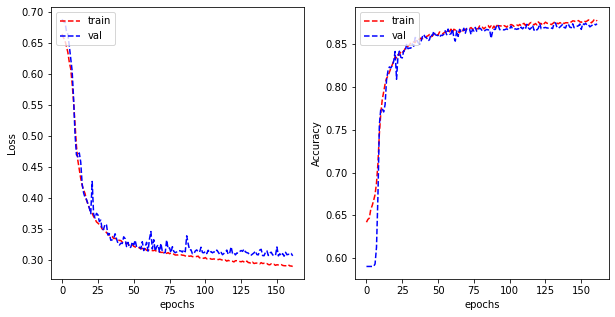

In [72]:
PlotModelFitHistory(history_VGG_2)

In [73]:
(test_y, pred_y) = PredictModel(model_VGG_2)

In [74]:
ShowStats(test_y, pred_y)

Accuracy score:  0.8826898661126501
F1 score:  0.8635503229357736
              precision    recall  f1-score   support

           0       0.87      0.97      0.91     45004
           1       0.92      0.72      0.81     24308

    accuracy                           0.88     69312
   macro avg       0.90      0.85      0.86     69312
weighted avg       0.89      0.88      0.88     69312



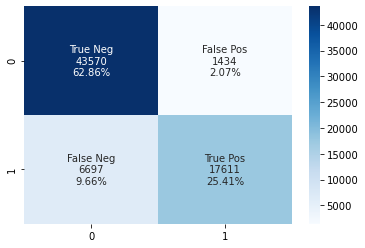

In [75]:
PlotConfusionMatrix(test_y, pred_y)

### Observations
* The model still took a long time to train
* There looks to be minimal overfitting
* Reducing the number of epochs to 50 showed minimal loss issues but accuracy was jumbled

## 6. SC-CNN 
* Try model based on SC-CNN 
* We have 20k images so that should be ok for training

In [76]:
model_SC_CNN_1 = tf.keras.Sequential([
    # Convolution
    
    tf.keras.layers.Conv2D(24, (4, 4), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(36, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid' )
    
])

In [77]:
CompileModel(model_SC_CNN_1)

In [78]:
history_SC_CNN_1 = FitModel(model_SC_CNN_1)

start  23:28:24
Epoch 1/10000
471/471 [==============================] - 13s 26ms/step - loss: 0.6062 - categorical_accuracy: 0.6639 - val_loss: 0.6131 - val_categorical_accuracy: 0.5921
Epoch 2/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.5509 - categorical_accuracy: 0.6878 - val_loss: 0.5363 - val_categorical_accuracy: 0.7290
Epoch 3/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.4870 - categorical_accuracy: 0.7690 - val_loss: 0.4760 - val_categorical_accuracy: 0.7637
Epoch 4/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.4375 - categorical_accuracy: 0.8097 - val_loss: 0.4172 - val_categorical_accuracy: 0.8357
Epoch 5/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.4104 - categorical_accuracy: 0.8211 - val_loss: 0.4166 - val_categorical_accuracy: 0.8082
Epoch 6/10000
471/471 [==============================] - 12s 26ms/step - loss: 0.3942 - categorical_accuracy: 0.8272 - val_loss: 

471/471 [==============================] - 12s 25ms/step - loss: 0.3196 - categorical_accuracy: 0.8640 - val_loss: 0.3367 - val_categorical_accuracy: 0.8602
Epoch 49/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.3198 - categorical_accuracy: 0.8633 - val_loss: 0.3283 - val_categorical_accuracy: 0.8651
Epoch 50/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.3198 - categorical_accuracy: 0.8642 - val_loss: 0.3258 - val_categorical_accuracy: 0.8651
Epoch 51/10000
471/471 [==============================] - 12s 26ms/step - loss: 0.3185 - categorical_accuracy: 0.8636 - val_loss: 0.3239 - val_categorical_accuracy: 0.8681
Epoch 52/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.3181 - categorical_accuracy: 0.8650 - val_loss: 0.3309 - val_categorical_accuracy: 0.8615
Epoch 53/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.3180 - categorical_accuracy: 0.8648 - val_loss: 0.3303 - val_categorical_

Epoch 96/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.2998 - categorical_accuracy: 0.8750 - val_loss: 0.3318 - val_categorical_accuracy: 0.8632
Epoch 97/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.2995 - categorical_accuracy: 0.8757 - val_loss: 0.3194 - val_categorical_accuracy: 0.8691
Epoch 98/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.2992 - categorical_accuracy: 0.8747 - val_loss: 0.3167 - val_categorical_accuracy: 0.8720
Epoch 99/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.2992 - categorical_accuracy: 0.8754 - val_loss: 0.3182 - val_categorical_accuracy: 0.8700
Epoch 100/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.2987 - categorical_accuracy: 0.8754 - val_loss: 0.3165 - val_categorical_accuracy: 0.8723
Epoch 101/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.2983 - categorical_accuracy: 0.8749 - val_loss: 0.3164 -

471/471 [==============================] - 12s 25ms/step - loss: 0.2860 - categorical_accuracy: 0.8816 - val_loss: 0.3153 - val_categorical_accuracy: 0.8736
Epoch 144/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.2860 - categorical_accuracy: 0.8821 - val_loss: 0.3219 - val_categorical_accuracy: 0.8668
Epoch 145/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.2856 - categorical_accuracy: 0.8838 - val_loss: 0.3202 - val_categorical_accuracy: 0.8678
Epoch 146/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.2851 - categorical_accuracy: 0.8827 - val_loss: 0.3353 - val_categorical_accuracy: 0.8632
Epoch 147/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.2849 - categorical_accuracy: 0.8832 - val_loss: 0.3127 - val_categorical_accuracy: 0.8743
Epoch 148/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.2852 - categorical_accuracy: 0.8817 - val_loss: 0.3117 - val_categor

471/471 [==============================] - 12s 25ms/step - loss: 0.2761 - categorical_accuracy: 0.8861 - val_loss: 0.3100 - val_categorical_accuracy: 0.8743
Epoch 191/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.2757 - categorical_accuracy: 0.8861 - val_loss: 0.3198 - val_categorical_accuracy: 0.8700
Epoch 192/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.2757 - categorical_accuracy: 0.8862 - val_loss: 0.3160 - val_categorical_accuracy: 0.8707
Epoch 193/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.2755 - categorical_accuracy: 0.8866 - val_loss: 0.3100 - val_categorical_accuracy: 0.8740
Epoch 194/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.2753 - categorical_accuracy: 0.8876 - val_loss: 0.3181 - val_categorical_accuracy: 0.8694
Epoch 195/10000
471/471 [==============================] - 12s 25ms/step - loss: 0.2752 - categorical_accuracy: 0.8863 - val_loss: 0.3146 - val_categor

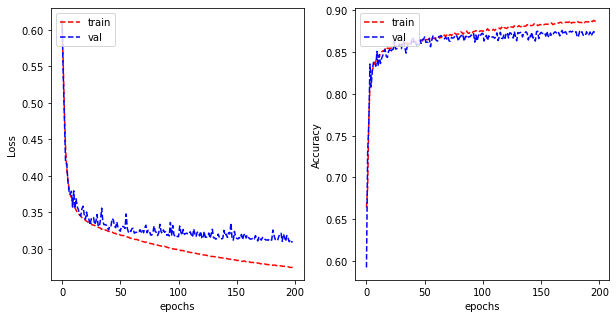

In [79]:
PlotModelFitHistory(history_SC_CNN_1)

In [80]:
(test_y, pred_y) = PredictModel(model_SC_CNN_1)

In [81]:
ShowStats(test_y, pred_y)

Accuracy score:  0.8860081948291783
F1 score:  0.8684104194016404
              precision    recall  f1-score   support

           0       0.87      0.96      0.92     44974
           1       0.92      0.74      0.82     24338

    accuracy                           0.89     69312
   macro avg       0.90      0.85      0.87     69312
weighted avg       0.89      0.89      0.88     69312



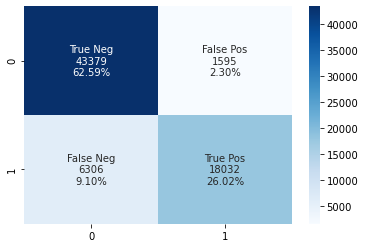

In [82]:
PlotConfusionMatrix(test_y, pred_y)

### Observations
* The model overfitted significantly
* Accuracy not correct

# 7. SC-CNN 2

In [83]:
model_SC_CNN_2 = tf.keras.Sequential([
    # Convolution
    
    tf.keras.layers.Conv2D(24, (4, 4), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(36, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
      
    tf.keras.layers.Dropout(.2),
    
    tf.keras.layers.Dense(
        OUTPUT_CLASSES, 
        kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        activation='sigmoid' )
    
])

Still didn't pickup anything

# 8. SC-CNN 3

In [84]:
model_SC_CNN_3 = tf.keras.Sequential([
    # Convolution
    
    tf.keras.layers.Conv2D(24, (4, 4), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(36, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        
    tf.keras.layers.Dense(
        OUTPUT_CLASSES, 
        kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        activation='sigmoid' )
    
])

# Model comparison and ultimate judgment

The base MLP model show overfitting
Using Regularistion resulted in a better model
Applying dropout also reduced overfitting but not the the same extent as regularisation 

Using the base VGG achitecture resulted in a small amount of overfitting
As the size of the inputs are quite low reducing the number of convolutions and adding some regulariation in the final MLP 
latyer might create a better model. 

All base models showed good results with 100% recall
Given the training time and simplicity the MLP with regularisation would be the best model

# Questions
* Results are the same for all models - looks bad but I can work out why
* accuracy jumps around but how to set learning rate?